# Higher-Order Neural ODEs

Following [Dissecting Neural ODEs](www.aaaa.com), In this tutorial we show how to easily handle **higher-order neural ODEs** in `torchdyn`

A higher-order neural ODEs can be defined as the initial value problem 

$$
    \begin{aligned}
        &\frac{d^n \mathbf{z}}{ds^n} = f_\theta\left(s, \mathbf{x}, \mathbf{z}, \frac{d \mathbf{z}}{ds}, \frac{d^2 \mathbf{z}}{ds^2}, \dots, \frac{d^{n-1} \mathbf{z}}{ds^{n-1}}\right)\\
        &\mathbf{z}(0), \frac{d \mathbf{z}}{ds}(0), \frac{d^2 \mathbf{z}}{ds^2}(0), \dots, \frac{d^{n-1} \mathbf{z}}{ds^{n-1}}(0) = h_{\mathbf{x}}(\mathbf{x})\\
        &{\bf y} = h_{\bf y}\left(\mathbf{z}(S), \frac{d \mathbf{z}}{ds}(S), \frac{d^2 \mathbf{z}}{ds^2}(S), \dots, \frac{d^{n-1} \mathbf{z}}{ds^{n-1}}(S)\right)
    \end{aligned}
$$

In [4]:
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter
from torchdyn.datasets import *
from torchdyn.utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# quick run for automated notebook validation
dry_run = False

**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve the binary classification problem.



In [6]:
d = ToyDataset()
X, yn = d.generate(n_samples=2048, dataset_type='spirals', noise=.4)

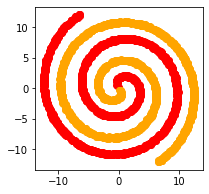

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.scatter(X[yn==0,0], X[yn==0,1], color='red')
ax.scatter(X[yn==1,0], X[yn==1,1], color='orange')

In [37]:
import torch
import torch.utils.data as data

device = 'cpu'

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

**Learner**

In [38]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)  
        loss = nn.CrossEntropyLoss()(y_hat[-1], y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

### Train a simple Second-Order Model 

Second order models have also been considered by [CITE]

We can train out of the box a 2nd order model for classification as follows

In [39]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(4, 64),
        nn.Tanh(), 
        nn.Linear(64, 2))

# Neural ODE
model = NeuralODE(f, 
                 order=2,
                 solver='dopri5', 
                 sensitivity='adjoint',
                 return_t_eval=False).to(device)

seq = nn.Sequential(Augmenter(1, 2, order='last'), model, nn.Linear(4, 2)).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [40]:
# train the neural ODE
learn = Learner(seq)
if dry_run: trainer = pl.Trainer(max_epochs=1)
else: trainer = pl.Trainer(max_epochs=800)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 460   
-------------------------------------
460       Trainable params
0         Non-trainable params
460       Total params
0.002     Total estimated model params size (MB)
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `Da

Training: 0it [00:00, ?it/s]

In [24]:
# Evaluate the data trajectories
t_span = torch.linspace(0,1,100)
X_d = seq[0](X_train[::10,:])
_, trajectory = model.trajectory(X_d, t_span)
trajectory = trajectory.detach().cpu()

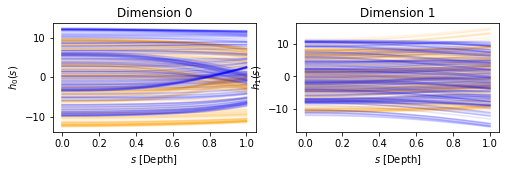

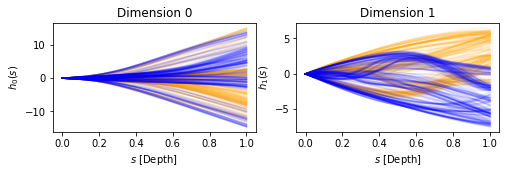

In [25]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(t_span, trajectory[:,:,:2], yn[::10], len(X)//10)
plot_2D_depth_trajectory(t_span, trajectory[:,:,2:4], yn[::10], len(X)//10)

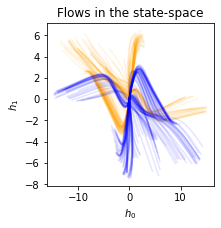

In [26]:
# Trajectories in the state-space
plot_2D_state_space(trajectory[:,:,-2:], yn[::10], len(X)//10)

Let us now train a higher--order model, e.g. 10th order, on the same task

### Showcase of Higher-Order Models (10th order Neural ODE)

Here, we introduce an integral regularization term leveraing the [generalized adjoint](https://arxiv.org/abs/2003.08063) for Neural ODEs.

In [27]:
class IntegralWReg(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self, s, x):
        loss = 1e-6*torch.abs(self.f(x)).sum(1) 
        return loss

With `torchdyn`, going beyond orders 1 and 2 is easy. Simply use the `order` argument during `NeuralDE` instantiations.

In [29]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(20, 128),
        nn.Tanh(), 
        nn.Linear(128, 2))

# Neural ODE
model = NeuralODE(f, 
                 order=10,
                 solver='dopri5', 
                 sensitivity='adjoint', 
                 integral_loss=IntegralWReg(f),
                 return_t_eval=False).to(device)

seq = nn.Sequential(Augmenter(1, 18, order='last'), model, nn.Linear(20,2)).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Note that the training will be slower than `order=1` Neural ODEs: higher order dynamics are often more challenging to integrate, and adaptive-step solvers will require higher NFEs.

In [30]:
# train the neural ODE
learn = Learner(seq)
if dry_run: trainer = pl.Trainer(max_epochs=1)
else: trainer = pl.Trainer(max_epochs=800)
trainer.fit(learn)
# Don't be alarmed by oscillations of the "terminal" loss (printed at every iter)! Having also an "integral" loss term, 
# it is the sum of the two that really matters.
# To monitor integral losses during training, see the tutorial in `module2` on integral losses via adjoints.

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 3.0 K 
-------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `Da

Training: 0it [00:00, ?it/s]

/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


**Plots**

In [33]:
# Evaluate the data trajectories
t_span = torch.linspace(0,1,100)
X_d = seq[0](X_train[::10,:])
_, trajectory = model.trajectory(X_d, t_span)
trajectory = trajectory.detach().cpu()

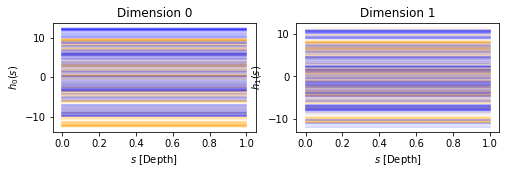

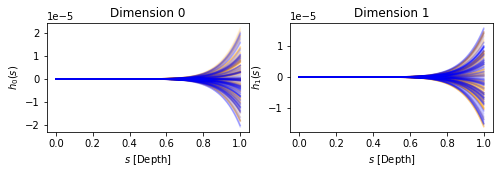

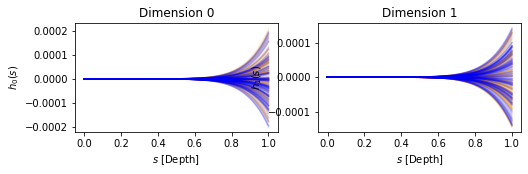

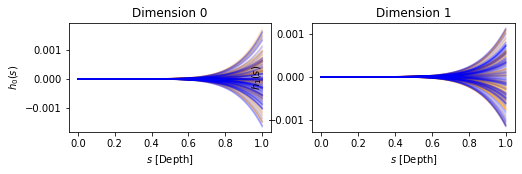

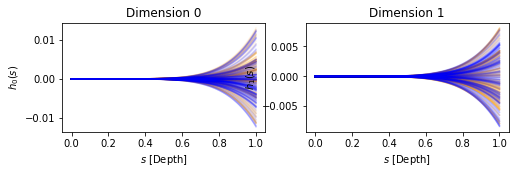

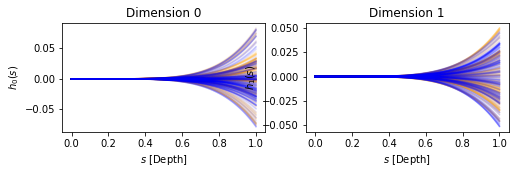

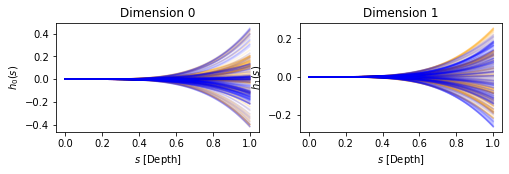

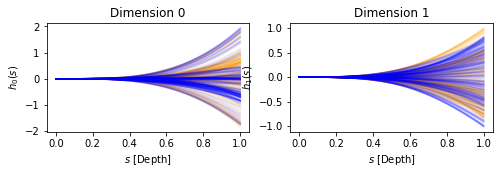

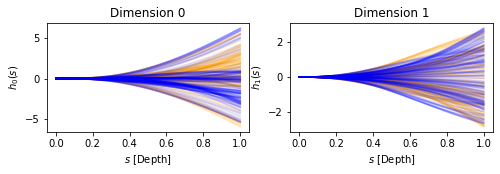

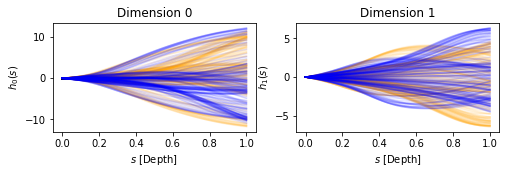

In [34]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(t_span, trajectory[:,:,:2], yn[::10], len(X)//10)
plot_2D_depth_trajectory(t_span, trajectory[:,:,2:4], yn[::10], len(X)//10)
plot_2D_depth_trajectory(t_span, trajectory[:,:,4:6], yn[::10], len(X)//10)
plot_2D_depth_trajectory(t_span, trajectory[:,:,6:8], yn[::10], len(X)//10)
plot_2D_depth_trajectory(t_span, trajectory[:,:,8:10], yn[::10], len(X)//10)
plot_2D_depth_trajectory(t_span, trajectory[:,:,10:12], yn[::10], len(X)//10)
plot_2D_depth_trajectory(t_span, trajectory[:,:,12:14], yn[::10], len(X)//10)
plot_2D_depth_trajectory(t_span, trajectory[:,:,14:16], yn[::10], len(X)//10)
plot_2D_depth_trajectory(t_span, trajectory[:,:,16:18], yn[::10], len(X)//10)
plot_2D_depth_trajectory(t_span, trajectory[:,:,18:20], yn[::10], len(X)//10)

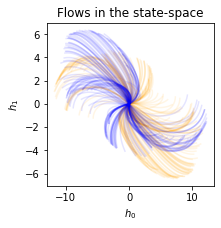

In [35]:
# Trajectories in the state-space
plot_2D_state_space(trajectory[:,:,-2:], yn[::10], len(X)//10)